# Applications of GARCH model to risk modeling

This notebook was prepared by: 

Vinicius Moreira (vgm236@nyu.edu)

Graduate School of Arts and Science (GSAS) at New York University (NYU)

May 2022

This notebook discusses the Generalized AutoRegressive Conditional Heteroskedasticity (GARCH) and its applications. We first briefly explain some of its history, the math, the logic and the program behind this method. Then, we apply the GARCH model into two similar, but different models: the Value-At-Risk (Var) and the Expected Shortfall (ES).

This is part of the QuantEcon class at NYU called Dynamic Models for Computational Social Science, taught by Drs. Thomas Sargent, Spencer Lyon and Chase Coleman.

In [1]:
#Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_datareader import DataReader
import datetime
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import levy
import seaborn as sns
import statsmodels.api as sm
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (10,8)

%matplotlib inline

## A brief history of the GARCH family and risk modeling

From the work of Markowitz, Tobin and Sharpe, risk was associated with variance in the value of a portfolio. So was born the Capital Asset Pricing Model or CAPM, which describes that there is a natural relation between expected returns and variance. When practitioners implemented these financial strategies, they required estimates of the variances - but those change over time.

One approach could be to calculate the historical square root of the variance, called volatility. But this is an estimate about the average of the past, not about the future. It also create the problem that volatility/variance for a given period could be different from another one.

With this in mind, a theory for dynamic volatility was developed mainly by the work of Nobel prize winner Robert F. Engle, first with the invention of the Autoregressive Conditional Heteroskedasticity (ARCH) model. This work was then further developed, notably by Tim Bollerslev, who developed the Generalized ARCH (GARCH) model as a doctoral student under the supervision of Dr. Engle.


Engle described the main benefits of the dynamic model of volatility:

- Parameters can be estimated by Maximum Likelihood. 

- Tests of the adequacy and accuracy can be used. 
 
- One-step and multi-step forecasts can be constructed.

- Unconditional distributions can be established mathematically and are generally realistic. 

- Inserting the relevant variables into the model can test economic models that seek to determine the causes and consequences of volatility.

Returns have three main characteristics: unpredictability, fat tails and volatility clustering. The models here were formed precisely to deal with these characteristics.

## Volatility: stylized facts

Volatility has important stylized facts:

1. It exhibits persistency: clustering of small and large moves.

2. Volatility is mean reverting: there is a "normal" level of volatility.

3. Exogenous variables may influence volatility: e.g. a recession somewhere in the World; earnings announcements.

4. Asset returns have heavy tails: larger periods of highly negative or positive returns than a Normal distribution would suggest.

5. Innovations may have an asymmetric impact on volatility, which GARCH models don't capture (TARCH for Threshold ARCH does capture that).

The returns and volatility of Nasdaq since 2000, shown in the first two charts below, reveal at least four of these stylized facts about volatility. 

For example, it is clear that periods of high volatility are often followed by periods of high volatility; volatility at some point returns to "normal" levels; volatility is influenced by exogenous factors (example: COVID-19 period); and there are clear periods of highly negative and positive returns periods. 

The third chart shows more clearly the heavy tails and the asymmetry volatility.

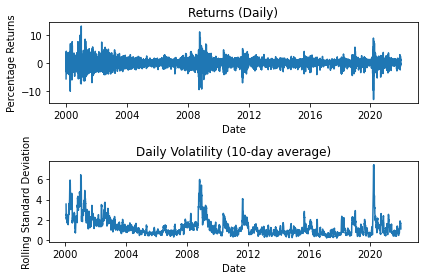

In [2]:
# Download and transform data
def download_transform(asset_name, initial_date, end_date):
    """
    Request data for one asset, from Fred's website, between ``initial_date`` and ``end_date``
    
    Parameters
    ----------
    asset_name: string
        A list one ID to request from Fred's website
    
    initial_date, end_date: integer
        Starting and ending years for period of data. All intervals between
        these two years (inclusive) will be reported
    
    Returns
    -------
    asset_returns: DataFrame
        A historical series of the daily returns in percentage
    """
    asset = DataReader(asset_name, "fred", initial_date, end_date).dropna()
    asset_returns = np.log(asset).diff().dropna()*100
    
    return asset_returns

# Function to calculate the rolling volatility
def rolling_vol(asset_returns, rolling_window):
    """
    Transforms returns into a rolling window of volatility
    
    Parameters
    ----------
    asset_returns: DataFrame
    A historical series of the daily returns in percentage
    
    rolling_window: string
        The volatility window
    
    Returns
    -------
    asset_returns: DataFrame
        A historical series of the rolling volatility/standard deviation
    """
    rolling_vol = asset_returns.rolling(rolling_window).std().dropna()

    return rolling_vol

# Function to plot returns and volatility
def plot_return_vol(asset_returns, rolling_vol):
    """
    Plots asset returns and rolling volatilities separately
    
    Parameters
    ----------
    asset_returns: DataFrame
    A historical series of the daily returns in percentage
    
    rolling_vol: DataFrame
        A historical series of the rolling volatility/standard deviation
    
    Returns
    -------
    Plot two charts of both the historical rolling volatility/standard deviation and the returns
    """
    # Create first subplot
    plt.subplot(2, 1, 1)
    
    # Plot first chart with legends, title etc.
    plt.plot(asset_returns)
    plt.title("Returns (Daily)")
    plt.xlabel('Date')
    plt.ylabel('Percentage Returns')
    
    # Create second subplot
    plt.subplot(2, 1, 2)
    
    # Plot second chart with legends, title etc.
    plt.plot(rolling_vol)
    plt.title("Daily Volatility (10-day average)")
    plt.xlabel('Date')
    plt.ylabel('Rolling Standard Deviation')
    
    # Set tight layout
    plt.tight_layout()
    
# Download data from 1970 to 2022
nasdaq = download_transform("NASDAQCOM", 2000, 2022).rename(columns={"NASDAQCOM": 'Nasdaq_Returns'})

# Show 20-day rolling window of volatility
nasdaq_vol10 = rolling_vol(nasdaq, 10).rename(columns={"Nasdaq_Returns": 'Nasdaq_Vol'})

# Plot chart of both series together
plot_return_vol(nasdaq, nasdaq_vol10)

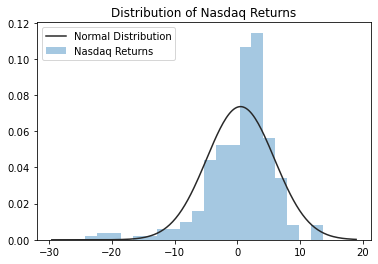

In [3]:
# Function to plot monthly returns in a histogram
def plot_histogram(asset_name, initial_date, end_date):
    """
    Request data for one asset, from Fred's website, between ``initial_date`` and ``end_date``
    
    Parameters
    ----------
    asset_name: string
        A list one ID to request from Fred's website
    
    initial_date, end_date: integer
        Starting and ending years for period of data. All intervals between
        these two years (inclusive) will be reported
    
    Returns
    -------
    Plot one charts with the histogram and normal distribution
    """
    # Get level
    daily_level = DataReader(asset_name, "fred", initial_date, end_date).dropna()

    # Get monthly returns
    monthly = np.log(daily_level.groupby(pd.PeriodIndex(daily_level.index, freq='M')).mean()).diff().dropna()*100

    # Chart monthly distribution of returns and Normal
    sns.distplot(monthly, fit=norm, kde=False).set(title='Distribution of Nasdaq Returns')

    # Add legend
    plt.legend(labels=["Normal Distribution","Nasdaq Returns"])


plot_histogram("NASDAQCOM", 2000, 2022)

## The math behind the GARCH model

Today, the most used model is the GARCH model. This turns the purely autoregressive model (ARCH) into an autoregressive moving average model, as we describe mathematically in the next section. 

The GARCH forecast of variance is a weighted average of three different variance forecasts. One is a constant variance that corresponds to the long run average. The second is the new information that was not available when the previous forecast was made. The third is the forecast that was made in previous period.

Take first the example of the GARCH(1,1) model to describe more simply the model, which is then generalized.

\begin{align*}
  \sigma^2_{t+1} &= \omega + \alpha \varepsilon_{t}^2 + \beta \sigma^2_t \\
\end{align*}

This formulation checks three of the stylized facts of volatility. The $\beta$ reveals that past volatility affects current volatility, which shows persistency. The $\alpha$ shows how other variables - in this case, a shock coming from the residual term - can affect volatility and perpetuated throughout the system. 

To present how volatility is mean reverting, $\beta$ must be $\le1$; otherwise, volatility's behavior is explosive. That said, the formula of long-run GARCH (1,1) model is:

\begin{align*}
  \sigma^2_{LR} &= E ( \omega + \alpha \varepsilon_{t}^2 + \beta \sigma^2_t ) \\  
\end{align*}


\begin{align*}
  \sigma^2_{LR} &= \omega + \alpha E (\varepsilon_{t}^2) + \beta E (\sigma^2_t ) \\  
\end{align*}

\begin{align*}
  \sigma^2_{LR} &= \omega + \alpha \sigma^2_{LR} + \beta \sigma^2_{LR} \\  
\end{align*}

\begin{align*}
  \sigma^2_{LR} &= \frac{\omega}{1 - \alpha -\beta}  \\  
\end{align*}

where $\alpha + \beta \le 1$

In this sense, when this model was described as a weighted average a constant variance, the new information and the forecast at $t-1$, their weights are, respectively: 

\begin{align*}
  \\ (\frac{\omega}{1 - \alpha -\beta} , \alpha , \beta ) \\  
\end{align*}



A more general version of the model can be written, with as many lags as required, the GARCH (p,q):

\begin{align*}
  \sigma^2_{t+1} = \omega + \sum_{j=0}^q \alpha_j \varepsilon^2_{t-j} + \sum_{j=0}^p \beta_j \sigma^2_{t-j}
\end{align*}

Note that this formulation cannot capture an asymmetric in the volatility behavior, which would be done by using EGARCH or GJR-GARCH (TARCH) models. We use EGARCH in one of the next sections.

## Application of GARCH: Value-At-Risk

Measuring risk of a portfolio has been a focus of many economists with different measures being proposed. Value-At-Risk (VaR) measures a monetary number of the potential loss of the portfolio. These measures appeared primarely in a theoretical environment in the 50s and 60s. Early implementations of VaR or VaR-like measures started in trading environments during the 1970’s or 1980’s. This model was popularized in the beginning of the 90s by JP Morgan's RiskMetrics team.

While the idea has been in theory since at least the 50's such model had difficulties of implementation. For example, if one wanted to calculate the 99%-percentile (or $ \alpha =  1$%) worst case scenario for your portfolio. One can calculate this by the historical distribution of the portfolio performance, but then it comes down to the same problem we had before - history doesn't show the risk now or in the future. 

With a good volatility forecast, on the other hand, you can calculate the VaR into the future. That's when the GARCH model comes in.

We will now implement the VaR model to show how it works. Then, we briefly discuss its shortcomings and apply a asymmetric model to deal with one of them. And finally, we present an alternative Expected Shortfall (ES) model to deal with other potential problems of the VaR.

#### GARCH-based VaR with empirical errors

To apply the VaR, we first need to make the GARCH predictions to estimate volatility for a given asset (NASDAQ index in this case). It will be a backward looking exercise, but it can be done the same with forecasts. We don't make assumptions about the errors for estimating the VaR, we use an empirical approach to estimate the quantiles. 

Alternatively, one can assume a given distribution such as the Normal Distribution. In that case, you would only need to multiply the volatility by the Z-score instead of the empirical quantile we use.

Our investment will have a theoretical value of $1,000.

**Step 1**: Use GARCH model to calculate variance/volatility (backward looking)

In [4]:
# Specify portfolio value
portfolio_value = 1_000

# Specify and fit a GARCH model (note returns in percentage now, divide by 100)
garch_nasdaq = arch_model(nasdaq/100, p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist="StudentsT")
garch_nasdaq_result = garch_nasdaq.fit()

# Print model
print(garch_nasdaq_result.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 903425.7865303945
Iteration:      2,   Func. Count:     23,   Neg. LLF: 106370.45149375942
Iteration:      3,   Func. Count:     33,   Neg. LLF: 51463.34868274923
Iteration:      4,   Func. Count:     44,   Neg. LLF: 6122115.201563437
Iteration:      5,   Func. Count:     60,   Neg. LLF: 63555.30682986457
Iteration:      6,   Func. Count:     66,   Neg. LLF: 64949.03558799121
Iteration:      7,   Func. Count:     76,   Neg. LLF: 54251.88809932546
Iteration:      8,   Func. Count:     82,   Neg. LLF: 50476.59276173662
Iteration:      9,   Func. Count:     88,   Neg. LLF: 27477.14625550196
Iteration:     10,   Func. Count:     94,   Neg. LLF: 41188.02399205971
Iteration:     11,   Func. Count:    101,   Neg. LLF: 22122.593862377667
Iteration:     12,   Func. Count:    108,   Neg. LLF: 15576.822195681278
Iteration:     13,   Func. Count:    115,   Neg. LLF: 9948.216351680472
Iteration:     14,   Func. Count:    123,   Neg. LLF: -7120.2

**Step 2**: Use GARCH model to obtain mean and volatility

In [5]:
# Estimate conditional volatility
nasdaq_vol = garch_nasdaq_result.conditional_volatility

# Estimate mean return
nasdaq_mean = (nasdaq/100).mean()

**Step 3**: Obtain the quantile according to a confidence level (we use 5%)

In [6]:
# Compute standardized residuals from the GARCH model
resid_nasdaq = garch_nasdaq_result.resid/nasdaq_vol

# Estimate quantiles based on the observed distribution of the GARCH standardized residuals
q_nasdaq_empirical = resid_nasdaq.quantile(0.05)

**Step 4**: Estimate the VaR given the equation:

\begin{align*}
  VaR = Portfolio value * ( mean + (GARCH vol) * quantile )
\end{align*}

Intuitively, this formula shows the return of that asset when the volatility is very high (at $\alpha$=5%). By multiplying by the portfolio value, we get those returns in dollars. 

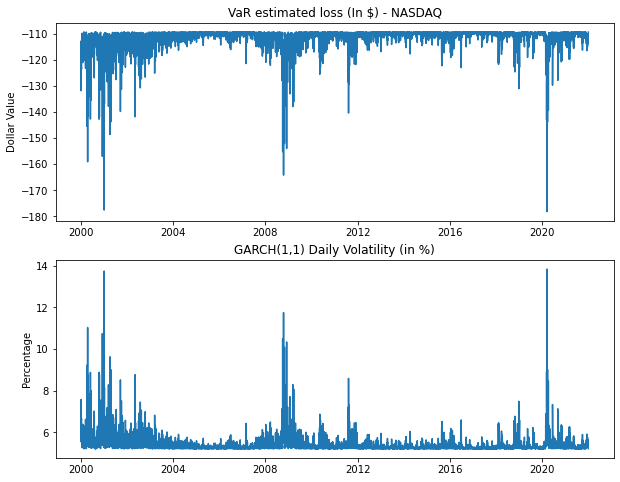

In [7]:
# Estimate VaR
Var_nasdaq = portfolio_value * (nasdaq_mean.values + np.sqrt(nasdaq_vol).values*q_nasdaq_empirical)

# PLot VaR and GARCH volatility
Var_nasdaq = pd.DataFrame(Var_nasdaq, columns = ['VaR (Nasdaq)'], index = nasdaq.index)

fig, ax = plt.subplots(2, figsize=(10, 8))
ax[0].set_title("VaR estimated loss (In $) - NASDAQ")
ax[0].set_ylabel("Dollar Value")
ax[0].plot(Var_nasdaq)
ax[1].set_title("GARCH(1,1) Daily Volatility (in %)")
ax[1].set_ylabel("Percentage")
ax[1].plot(nasdaq_vol*100)

This shows at some points in the sample, the value at risk is almost 20% of your investment in a single day. The COVID-19 shock by the end of the sample is a good example.

Now, we create a function to summarize the exercise above.

In [8]:
# Create a function that summarizes VaR
def VaR_one_asset(asset_name, initial_date, end_date, portfolio_value, p, q, quantile):
    """
    Request data for one asset, from Fred's website, between ``initial_date`` and ``end_date``
    Then, runs the Garch model for (p,q) lags
    Finally, runs a VaR based on one's portfolio value and the quantile of the distribution
    
    Parameters
    ----------
    asset_name: string
        A list one ID to request from Fred's website
    
    initial_date, end_date: integer
        Starting and ending years for period of data. All intervals between
        these two years (inclusive) will be reported

    portfolio_value: integer
        Hypothetical value of the investment made on that asset

    p,q: integer
        Lags of the GARCH(p,q)
        
    quantile: integer (in percentage)
        Quantile of the VaR estimate
        
    Returns
    -------
    VaR: DataFrame
        A series of daily Value-At-Risk based on a portfolio of one asset (in US$)

    vol: DataFrame
        A series of daily GARCH(p,q) volatility estimates
    
    """
    # Get Asset and Asset returns
    asset = DataReader(asset_name, "fred", initial_date, end_date).dropna()
    asset_returns = np.log(asset).diff().dropna()
    
    # Specify and fit a GARCH model (note returns in percentage now, divide by 100)
    garch = arch_model(asset_returns, p = p, q = q, mean = 'constant', vol = 'GARCH', dist="StudentsT")
    garch_result = garch.fit()
    
    # Estimate conditional volatility
    vol = garch_result.conditional_volatility
    # Estimate mean return
    mean = asset_returns.mean()

    # Compute standardized residuals from the GARCH model
    resid = garch_result.resid/vol

    # Estimate quantiles based on the observed distribution of the GARCH standardized residuals
    q_empirical = resid.quantile(quantile)
    
    # Estimate VaR
    VaR = portfolio_value * (mean.values + np.sqrt(vol).values*q_empirical)

    # Put together VaR and GARCH volatility
    VaR = pd.DataFrame(VaR, columns = ['VaR'], index = asset_returns.index)

    return VaR, vol   

Iteration:      1,   Func. Count:      7,   Neg. LLF: 903425.7865303945
Iteration:      2,   Func. Count:     23,   Neg. LLF: 106370.45149375942
Iteration:      3,   Func. Count:     33,   Neg. LLF: 51463.34868274923
Iteration:      4,   Func. Count:     44,   Neg. LLF: 6122115.201563437
Iteration:      5,   Func. Count:     60,   Neg. LLF: 63555.30682986457
Iteration:      6,   Func. Count:     66,   Neg. LLF: 64949.03558799121
Iteration:      7,   Func. Count:     76,   Neg. LLF: 54251.88809932546
Iteration:      8,   Func. Count:     82,   Neg. LLF: 50476.59276173662
Iteration:      9,   Func. Count:     88,   Neg. LLF: 27477.14625550196
Iteration:     10,   Func. Count:     94,   Neg. LLF: 41188.02399205971
Iteration:     11,   Func. Count:    101,   Neg. LLF: 22122.593862377667
Iteration:     12,   Func. Count:    108,   Neg. LLF: 15576.822195681278
Iteration:     13,   Func. Count:    115,   Neg. LLF: 9948.216351680472
Iteration:     14,   Func. Count:    123,   Neg. LLF: -7120.2

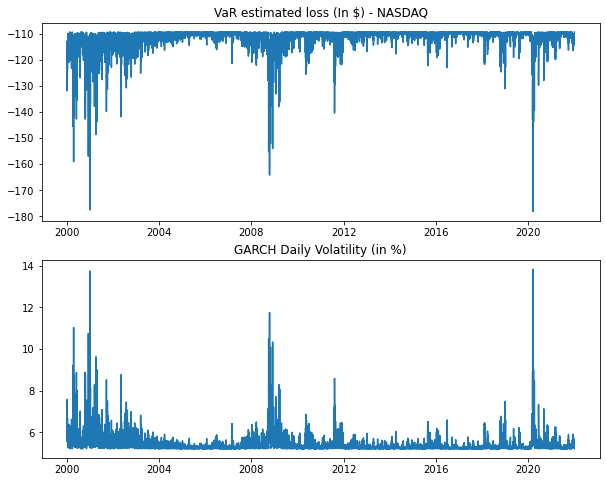

In [9]:
VaR, vol = VaR_one_asset("NASDAQCOM", 2000, 2022, 1000, 1, 1, 0.05)

fig, ax = plt.subplots(2, figsize=(10, 8))
ax[0].set_title("VaR estimated loss (In $) - NASDAQ")
ax[0].plot(VaR)
ax[1].set_title("GARCH Daily Volatility (in %)")
ax[1].plot(vol*100)

Now, we can run this function for trading the exchange rate dollar vs. Mexican peso (USDMXN) since 1993, using GARCH(1,1):

Iteration:      1,   Func. Count:      6,   Neg. LLF: -26400.036592407418
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -26400.03659230577
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1


C:\Users\19175\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


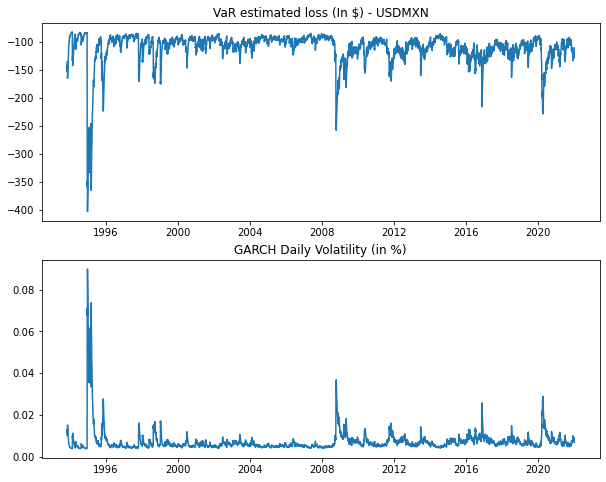

In [10]:
VaR, vol = VaR_one_asset("DEXMXUS", 1993, 2022, 1000, 1, 1, 0.05)

fig, ax = plt.subplots(2, figsize=(10, 8))
ax[0].set_title("VaR estimated loss (In $) - USDMXN")
ax[0].plot(VaR)
ax[1].set_title("GARCH Daily Volatility (in %)")
ax[1].plot(vol)

In the case of this USDMXN, in 1994 the investor could lose 40% of its investment in this exchange rate in an episode called the "Tequila Crisis."

Note, however, that these estimates represent only one day change. Intuitively, for longer periods (e.g. 10 days) the losses could be even larger. 

## Application of GARCH: Value-At-Risk, asymmetric

To deal with the problem of asymmetry, we then start using the EGARCH model instead of the traditional GARCH. As we mentioned before, there is a stylized fact that the EGARCH model captures that is not contemplated by the GARCH model, which is the empirically observed fact that negative shocks at time $t−1$ have a stronger impact in the variance at time t than positive shocks.

The EGARCH model does not require any restriction on the parameters because, since the equation is on log variance instead of variance itself, the positivity of the variance is automatically satisfied, and that is the main advantage of the EGARCH model. In general, the likelihood maximization with no restrictions results in faster and more reliable optimizations.

The EGARCH(1,1) is defined as follows in Nelson (1991). A generalization would be similar to what was done for the GARCH.

\begin{align*}
  log(\sigma^2_{t+1}) &= \omega + log(\beta \sigma^2_t) + \alpha |\frac{\varepsilon_{t}}{\sigma_t}| + \gamma \frac{\varepsilon_{t}}{\sigma_t}  \\
\end{align*}

If $\beta$ and $\gamma$ are equal in module, then there's no asymmetry. The Nasdaq returns, as we described in the histogram, present this asymmetry with more volatility during periods of negative returns.

In [11]:
# Specify portfolio value
portfolio_value = 1_000

# Specify and fit a GARCH model (note returns in percentage now, divide by 100)
garch_nasdaq2 = arch_model(nasdaq/100, p = 1, q = 1, o=1, mean = 'constant', vol = 'EGARCH')
garch_nasdaq_result2 = garch_nasdaq2.fit()

# Print model
print(garch_nasdaq_result2.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6.616609025393514e+19
Iteration:      2,   Func. Count:     21,   Neg. LLF: 15051893030736.512
Iteration:      3,   Func. Count:     31,   Neg. LLF: 902401199719.1803
Iteration:      4,   Func. Count:     41,   Neg. LLF: 7863032204904.095
Iteration:      5,   Func. Count:     51,   Neg. LLF: 364.2204475243366
Iteration:      6,   Func. Count:     60,   Neg. LLF: -16580.066300231054
Iteration:      7,   Func. Count:     67,   Neg. LLF: -16597.270479503604
Iteration:      8,   Func. Count:     73,   Neg. LLF: -16597.273019345423
Iteration:      9,   Func. Count:     79,   Neg. LLF: -16597.27308656738
Iteration:     10,   Func. Count:     85,   Neg. LLF: -16597.273089318543
Iteration:     11,   Func. Count:     90,   Neg. LLF: -16597.273089319602
Optimization terminated successfully    (Exit mode 0)
            Current function value: -16597.273089318543
            Iterations: 11
            Function evaluations: 90
            Gradie

Therefore, if we run the VaR using EGARCH instead of GARCH, the value at risk is generally larger in periods of high volatility. Notably, instead of losses of about 20%, the EGARCH shows that the value-at-risk can be up to more than 40% at times.

In [12]:
# Create a function that summarizes VaR with EGARCH
def VaR_EGARCH(asset_name, initial_date, end_date, portfolio_value, p, q, quantile):
    """
    Request data for one asset, from Fred's website, between ``initial_date`` and ``end_date``
    Then, runs the Garch model for (p,q) lags
    Finally, runs a VaR based on one's portfolio value and the quantile of the distribution
    
    Parameters
    ----------
    asset_name: string
        A list one ID to request from Fred's website
    
    initial_date, end_date: integer
        Starting and ending years for period of data. All intervals between
        these two years (inclusive) will be reported

    portfolio_value: integer
        Hypothetical value of the investment made on that asset

    p,q: integer
        Lags of the GARCH(p,q)
        
    quantile: integer (in percentage)
        Quantile of the VaR estimate
        
    Returns
    -------
    VaR: DataFrame
        A series of daily Value-At-Risk based on a portfolio of one asset (in US$)

    vol: DataFrame
        A series of daily GARCH(p,q) volatility estimates
    
    """
    # Get Asset and Asset returns
    asset = DataReader(asset_name, "fred", initial_date, end_date).dropna()
    asset_returns = np.log(asset).diff().dropna()
    
    # Specify and fit a GARCH model (note returns in percentage now, divide by 100)
    garch = arch_model(asset_returns, p = p, q = q, mean = 'constant', vol = 'EGARCH')
    garch_result = garch.fit()
    
    # Estimate conditional volatility
    vol = garch_result.conditional_volatility
    # Estimate mean return
    mean = asset_returns.mean()

    # Compute standardized residuals from the GARCH model
    resid = garch_result.resid/vol

    # Estimate quantiles based on the observed distribution of the GARCH standardized residuals
    q_empirical = resid.quantile(quantile)
    
    # Estimate VaR
    VaR = portfolio_value * (mean.values + np.sqrt(vol).values*q_empirical)

    # Put together VaR and GARCH volatility
    VaR = pd.DataFrame(VaR, columns = ['VaR'], index = asset_returns.index)

    return VaR, vol  

VaR, vol = VaR_one_asset("NASDAQCOM", 2000, 2022, 1000, 1, 1, 0.05)
EGARCH, vol_EGARCH = VaR_EGARCH("NASDAQCOM", 2000, 2022, 1000, 1, 1, 0.05)


Iteration:      1,   Func. Count:      7,   Neg. LLF: 903425.7865303945
Iteration:      2,   Func. Count:     23,   Neg. LLF: 106370.45149375942
Iteration:      3,   Func. Count:     33,   Neg. LLF: 51463.34868274923
Iteration:      4,   Func. Count:     44,   Neg. LLF: 6122115.201563437
Iteration:      5,   Func. Count:     60,   Neg. LLF: 63555.30682986457
Iteration:      6,   Func. Count:     66,   Neg. LLF: 64949.03558799121
Iteration:      7,   Func. Count:     76,   Neg. LLF: 54251.88809932546
Iteration:      8,   Func. Count:     82,   Neg. LLF: 50476.59276173662
Iteration:      9,   Func. Count:     88,   Neg. LLF: 27477.14625550196
Iteration:     10,   Func. Count:     94,   Neg. LLF: 41188.02399205971
Iteration:     11,   Func. Count:    101,   Neg. LLF: 22122.593862377667
Iteration:     12,   Func. Count:    108,   Neg. LLF: 15576.822195681278
Iteration:     13,   Func. Count:    115,   Neg. LLF: 9948.216351680472
Iteration:     14,   Func. Count:    123,   Neg. LLF: -7120.2

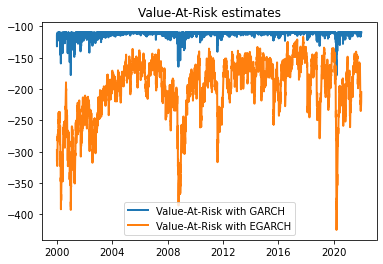

In [13]:
# Plot chart comparing GARCH and EGARCH VaR estimates
plt.plot(VaR, linewidth=2.0, label='Value-At-Risk with GARCH')
plt.plot(EGARCH, linewidth=2.0, label='Value-At-Risk with EGARCH')
plt.title('Value-At-Risk estimates')
plt.legend(loc="lower center")
plt.show()

## Application of GARCH: Expected Shortfall (ES)

While the VaR approach can be useful, it has one relevant problem.

The value shown in the charts is at the edge of 5% quantile of the distribution, as can be seen in the plot below that zooms in the 5% quantile of the distribution. On the 5% level, the loss is of 10%, but as you move further into the tail, it could reach up to 25%. 

However, when a crisis hits, there is an important part of the distribution that could generate even larger losses. In particular, the expected loss of a portfolio at the 5% quantile can be much higher than what is on the edge of the 5% quantile. 

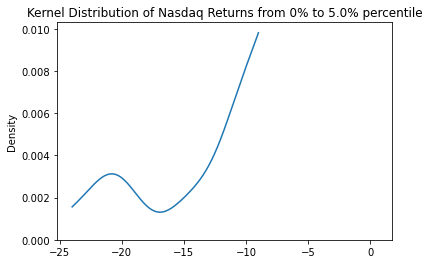

In [14]:
# Plot chart zooming in the 0-5% percentile of the tail for Nasdaq
def plot_quantile_histogram(asset_name, initial_date, end_date, quantile):
    """
    Request data for one asset, from Fred's website, between ``initial_date`` and ``end_date``
    
    Parameters
    ----------
    asset_name: string
        A list one ID to request from Fred's website
    
    initial_date, end_date: integer
        Starting and ending years for period of data. All intervals between
        these two years (inclusive) will be reported
    
    quantile: integer between 0 and 1
        The quantile of the distribution you want to zoom at
    
    Returns
    -------
    Plot the tail of the histogram of the asset returns
    """
    # Get level
    daily_level = DataReader(asset_name, "fred", initial_date, end_date).dropna()

    # Get monthly returns
    monthly = np.log(daily_level.groupby(pd.PeriodIndex(daily_level.index, freq='M')).mean()).diff().dropna()*100

    # Chart monthly distribution of returns and Normal
    sns.distplot(monthly, hist=False, kde=True, kde_kws={'clip': (int(monthly.quantile(0.0)), int(monthly.quantile(quantile)))}).set(title=f'Kernel Distribution of Nasdaq Returns from 0% to {quantile*100}% percentile')

plot_quantile_histogram("NASDAQCOM", 2000, 2022, 0.05)

That's when the Expected Shortfall (ES) methodology comes in. Expected shortfall is calculated by the expected loss (average) in the distribution that are worse than the VaR of the portfolio at a given level of confidence. 

The model therefore provides a much more negative result than the VaR. We compare the Expected Shortfall with our initial estimates of Value-At-Risk. Finally, we compare the ES and VaR using EGARCH volatility estimates.

In [15]:
# Create a function that summarizes Expected Shortfall
def ES_one_asset(asset_name, initial_date, end_date, portfolio_value, p, q, quantile):
    """
    Request data for one asset, from Fred's website, between ``initial_date`` and ``end_date``
    Then, runs the Garch model for (p,q) lags
    Finally, runs a VaR based on one's portfolio value and the quantile of the distribution
    
    Parameters
    ----------
    asset_name: string
        A list one ID to request from Fred's website
    
    initial_date, end_date: integer
        Starting and ending years for period of data. All intervals between
        these two years (inclusive) will be reported

    portfolio_value: integer
        Hypothetical value of the investment made on that asset

    p,q: integer
        Lags of the GARCH(p,q)
        
    quantile: integer (in percentage)
        Quantile of the VaR estimate
        
    Returns
    -------
    ES: DataFrame
        A series of daily Expected Shortfall based on a portfolio of one asset (in US$)

    vol: DataFrame
        A series of daily GARCH(p,q) volatility estimates
    
    """
    # Get Asset and Asset returns
    asset = DataReader(asset_name, "fred", initial_date, end_date).dropna()
    asset_returns = np.log(asset).diff().dropna()
    
    # Specify and fit a GARCH model (note returns in percentage now, divide by 100)
    garch = arch_model(asset_returns, p = p, q = q, mean = 'constant', vol = 'GARCH', dist="StudentsT")
    garch_result = garch.fit()
    
    # Estimate conditional volatility
    vol = garch_result.conditional_volatility
    # Estimate mean return
    mean = asset_returns.mean()

    # Compute standardized residuals from the GARCH model
    resid = garch_result.resid/vol

    # MAIN DIFFERENCE: Estimate the expected value after the quantile of the Var
    q_empirical = (resid.quantile(0) + resid.quantile(quantile)) / 2
    
    # Estimate VaR
    ES = portfolio_value * (mean.values + np.sqrt(vol).values*q_empirical)

    # PLot VaR and GARCH volatility
    ES = pd.DataFrame(ES, columns = ['VaR'], index = asset_returns.index)

    return ES, vol   

VaR, vol = VaR_one_asset("NASDAQCOM", 2000, 2022, 1000, 1, 1, 0.05)
ES, vol_ES = ES_one_asset("NASDAQCOM", 2000, 2022, 1000, 1, 1, 0.05)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 903425.7865303945
Iteration:      2,   Func. Count:     23,   Neg. LLF: 106370.45149375942
Iteration:      3,   Func. Count:     33,   Neg. LLF: 51463.34868274923
Iteration:      4,   Func. Count:     44,   Neg. LLF: 6122115.201563437
Iteration:      5,   Func. Count:     60,   Neg. LLF: 63555.30682986457
Iteration:      6,   Func. Count:     66,   Neg. LLF: 64949.03558799121
Iteration:      7,   Func. Count:     76,   Neg. LLF: 54251.88809932546
Iteration:      8,   Func. Count:     82,   Neg. LLF: 50476.59276173662
Iteration:      9,   Func. Count:     88,   Neg. LLF: 27477.14625550196
Iteration:     10,   Func. Count:     94,   Neg. LLF: 41188.02399205971
Iteration:     11,   Func. Count:    101,   Neg. LLF: 22122.593862377667
Iteration:     12,   Func. Count:    108,   Neg. LLF: 15576.822195681278
Iteration:     13,   Func. Count:    115,   Neg. LLF: 9948.216351680472
Iteration:     14,   Func. Count:    123,   Neg. LLF: -7120.2

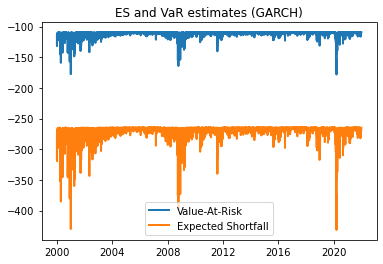

In [16]:
#plt.set_title("VaR and ES estimated loss (In $) - NASDAQ")
plt.plot(VaR, linewidth=2.0, label='Value-At-Risk')
plt.plot(ES, linewidth=2.0, label='Expected Shortfall')
plt.title('ES and VaR estimates (GARCH)')
plt.legend(loc="lower center")
plt.show()

In [17]:
# Create a function that summarizes Expected Shortfall with EGARCH
def ES_EGARCH(asset_name, initial_date, end_date, portfolio_value, p, q, quantile):
    """
    Request data for one asset, from Fred's website, between ``initial_date`` and ``end_date``
    Then, runs the Garch model for (p,q) lags
    Finally, runs a VaR based on one's portfolio value and the quantile of the distribution
    
    Parameters
    ----------
    asset_name: string
        A list one ID to request from Fred's website
    
    initial_date, end_date: integer
        Starting and ending years for period of data. All intervals between
        these two years (inclusive) will be reported

    portfolio_value: integer
        Hypothetical value of the investment made on that asset

    p,q: integer
        Lags of the GARCH(p,q)
        
    quantile: integer (in percentage)
        Quantile of the VaR estimate
        
    Returns
    -------
    ES: DataFrame
        A series of daily Expected Shortfall based on a portfolio of one asset (in US$)

    vol: DataFrame
        A series of daily GARCH(p,q) volatility estimates
    
    """
    # Get Asset and Asset returns
    asset = DataReader(asset_name, "fred", initial_date, end_date).dropna()
    asset_returns = np.log(asset).diff().dropna()
    
    # Specify and fit a GARCH model (note returns in percentage now, divide by 100)
    garch = arch_model(asset_returns, p = p, q = q, mean = 'constant', vol = 'EGARCH')
    garch_result = garch.fit()
    
    # Estimate conditional volatility
    vol = garch_result.conditional_volatility
    # Estimate mean return
    mean = asset_returns.mean()

    # Compute standardized residuals from the GARCH model
    resid = garch_result.resid/vol

    # MAIN DIFFERENCE: Estimate the expected value after the quantile of the Var
    q_empirical = (resid.quantile(0) + resid.quantile(quantile)) / 2
    
    # Estimate VaR
    ES = portfolio_value * (mean.values + np.sqrt(vol).values*q_empirical)

    # PLot VaR and GARCH volatility
    ES = pd.DataFrame(ES, columns = ['VaR'], index = asset_returns.index)

    return ES, vol   

VaR, vol = VaR_one_asset("NASDAQCOM", 2000, 2022, 1000, 1, 1, 0.05)
ES, vol_ES = ES_one_asset("NASDAQCOM", 2000, 2022, 1000, 1, 1, 0.05)
VaR_EGARCH, vol_EGARCH = VaR_EGARCH("NASDAQCOM", 2000, 2022, 1000, 1, 1, 0.05)
ES_EGARCH, vol_ES_EGARCH = ES_EGARCH("NASDAQCOM", 2000, 2022, 1000, 1, 1, 0.05)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 903425.7865303945
Iteration:      2,   Func. Count:     23,   Neg. LLF: 106370.45149375942
Iteration:      3,   Func. Count:     33,   Neg. LLF: 51463.34868274923
Iteration:      4,   Func. Count:     44,   Neg. LLF: 6122115.201563437
Iteration:      5,   Func. Count:     60,   Neg. LLF: 63555.30682986457
Iteration:      6,   Func. Count:     66,   Neg. LLF: 64949.03558799121
Iteration:      7,   Func. Count:     76,   Neg. LLF: 54251.88809932546
Iteration:      8,   Func. Count:     82,   Neg. LLF: 50476.59276173662
Iteration:      9,   Func. Count:     88,   Neg. LLF: 27477.14625550196
Iteration:     10,   Func. Count:     94,   Neg. LLF: 41188.02399205971
Iteration:     11,   Func. Count:    101,   Neg. LLF: 22122.593862377667
Iteration:     12,   Func. Count:    108,   Neg. LLF: 15576.822195681278
Iteration:     13,   Func. Count:    115,   Neg. LLF: 9948.216351680472
Iteration:     14,   Func. Count:    123,   Neg. LLF: -7120.2

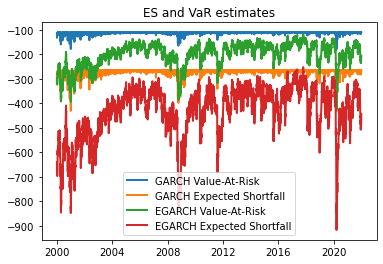

In [18]:
#plt.set_title("VaR and ES estimated loss (In $) - NASDAQ")
plt.plot(VaR, linewidth=2.0, label='GARCH Value-At-Risk')
plt.plot(ES, linewidth=2.0, label='GARCH Expected Shortfall')
plt.plot(VaR_EGARCH, linewidth=2.0, label='EGARCH Value-At-Risk')
plt.plot(ES_EGARCH, linewidth=2.0, label='EGARCH Expected Shortfall')
plt.title('ES and VaR estimates')
plt.legend(loc="lower center")
plt.show()

## Conclusion

This notebook discusses the Generalized AutoRegressive Conditional Heteroskedasticity (GARCH) and its applications. We first briefly explain some of its history, the math, the logic and the program behind this method. Then, we apply the GARCH model into two similar, but different models: the Value-At-Risk (Var) and the Expected Shortfall (ES). We extend this analysis by looking into the EGARCH volatility estimates to account for asymmetry of returns.

In general, we reinforce that the GARCH model is useful in the context of risk modeling to forecast and estimate volatility. The GARCH captures volatility persistency and clustering; the heavy tails of returns; and how exogenous factors can impact volatility. It does not capture the asymmetry of returns, which the EGARCH presented here does.

When applied to Value-At-Risk (VaR) models, the GARCH and EGARCH can provide estimates of potential one-day losses. However, VaRs can underestimate the risks as it captures only the border of the percentile considered (e.g. 5%). The Expected Shortfall (ES) model contributes in the sense that it shows the expected loss when negative returns exceed a given threshold (again, e.g. 5%). 

Our findings here show that EGARCH models provide higher volatilities estimates than GARCH. The ES model shows higher estimates of potential losses than the VaR. 

## References

Engle, Robert F. “Autoregressive Conditional Heteroscedasticity with Estimates of the Variance of United Kingdom Inflation.” Econometrica, vol. 50, no. 4, 1982, pp. 987–1007, https://doi.org/10.2307/1912773. Accessed 24 Apr. 2022.

Engle, Robert. “Risk and Volatility: Econometric Models and Financial Practice.” The American Economic Review, vol. 94, no. 3, 2004, pp. 405–20, http://www.jstor.org/stable/3592935. Accessed 24 Apr. 2022.

Engle, Robert F. and Patton, Andrew J., What Good is a Volatility Model? (January 2001). NYU Working Paper No. S-DRP-01-03, Available at SSRN: https://ssrn.com/abstract=1296430

Kaplanski, Guy and Kroll, Yoram, VAR Risk Measures Versus Traditional Risk Measures: An Analysis and Survey (December 1, 2001). Journal of Risk, Vol. 4, Issue 3, pp. 1-27, 2002, Available at SSRN: https://ssrn.com/abstract=271992 or http://dx.doi.org/10.2139/ssrn.271992

Holton, G.A. (2002) History of Value-at-Risk: 1922-1988. Contingency Analysis Working Paper.

Nelson, D. B., 1991. Conditional Heteroskedasticity in Asset Returns: A New Approach. Econometrica 59: 347-370. https://www.jstor.org/stable/2938260

NYU Stern Volatility-Lab. See more here: https://vlab.stern.nyu.edu/

Value at Risk (B): Portfolio Standard Deviation, (1999) Paul Glasserman, Columbia Business School. Available here: https://www0.gsb.columbia.edu/faculty/pglasserman/B6014/var-b.pdf.

Yang, Chelsea VaR in financial risk management: GARCH models in Python. Class from DataCamp. Available here: https://projector-video-pdf-converter.datacamp.com/22276/chapter4.pdf

